In [62]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
import csv
from PIL import Image
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [64]:
def load_gtsrb_dataset(csv_file, image_folder):
    images, labels = [], []
    with open(csv_file, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # Skip header
        for row in reader:
            # Ensure the image path is treated as a string and leading zeros are preserved
            image_path = os.path.join(image_folder, str(row[7]))  # Ensure Path column is taken as string
            label = int(row[6])  # ClassId is at index 6
            images.append(image_path)
            labels.append(label)
    return images, labels

In [65]:
def load_and_preprocess_images(image_paths, image_size=(32, 32)):
    images = []
    for image_path in image_paths:
        print(f"Processing image: {image_path}")  # Debugging: print image path
        full_path = Path(image_path).resolve()  # Get absolute path
        print(f"Full image path: {full_path}")  # Debugging: print absolute path
        
        if full_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
            try:
                if full_path.exists():
                    img = Image.open(full_path).convert('RGB')
                    img = img.resize(image_size)
                    img_array = np.array(img).flatten()
                    images.append(img_array)
                else:
                    print(f"Warning: {full_path} not found, skipping...")
            except Exception as e:
                print(f"Error processing {full_path}: {e}")
        else:
            print(f"Warning: {full_path} is not a valid image, skipping...")
    
    return np.array(images)

In [66]:
def handle_missing_data(images, labels, fill_missing_labels=-1):
    valid_images, valid_labels = [], []
    
    for img_path, label in zip(images, labels):
        # Check if image path is valid (not missing and the file exists)
        img_path = Path(img_path)  # Ensure the image path is a Path object
        
        if img_path.exists() and img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:  # Check if valid image file
            if label is not None:  # Ensure label is not missing
                valid_images.append(img_path)
                valid_labels.append(label)
            else:
                print(f"Warning: Missing label for image {img_path}, filling with {fill_missing_labels}")
                valid_images.append(img_path)
                valid_labels.append(fill_missing_labels)
        else:
            print(f"Warning: Invalid image path {img_path}, skipping...")

    return valid_images, valid_labels

In [67]:
def scale_features(train_images, test_images):
    # StandardScaler (z-score standardization)
    scaler = StandardScaler()
    scaled_train_images = scaler.fit_transform(train_images)
    scaled_test_images = scaler.transform(test_images)

    return scaled_train_images, scaled_test_images

In [68]:
def split_dataset(images, labels, test_size=0.2):
    return train_test_split(images, labels, test_size=test_size, random_state=42)


In [69]:
# Paths to dataset files
csv_file = "dataset/gtsrb/Test.csv"
image_folder = "dataset/gtsrb"

# Load dataset
images, labels = load_gtsrb_dataset(csv_file, image_folder)

cleaned_images, cleaned_labels = handle_missing_data(images, labels)

# Split dataset
train_images, test_images, train_labels, test_labels = split_dataset(cleaned_images, cleaned_labels)

# Check how many images are in the dataset
print(f"Total training images: {len(train_images)}")  # Debugging: check train images
train_images_preprocessed = load_and_preprocess_images(train_images)
print(f"Total preprocessed training images: {len(train_images_preprocessed)}")  # Debugging: check preprocessed images

# Similarly for test images:
print(f"Total test images: {len(test_images)}")  # Debugging: check test images
test_images_preprocessed = load_and_preprocess_images(test_images)
print(f"Total preprocessed test images: {len(test_images_preprocessed)}")  # Debugging: check preprocessed test images

scaled_train_images, scaled_test_images = scale_features(train_images_preprocessed, test_images_preprocessed)


Total training images: 10104
Processing image: dataset/gtsrb/Test/06693.png
Full image path: /Users/mohammadsalah/Desktop/GTSRB/dataset/gtsrb/Test/06693.png
Processing image: dataset/gtsrb/Test/01845.png
Full image path: /Users/mohammadsalah/Desktop/GTSRB/dataset/gtsrb/Test/01845.png
Processing image: dataset/gtsrb/Test/00111.png
Full image path: /Users/mohammadsalah/Desktop/GTSRB/dataset/gtsrb/Test/00111.png
Processing image: dataset/gtsrb/Test/00472.png
Full image path: /Users/mohammadsalah/Desktop/GTSRB/dataset/gtsrb/Test/00472.png
Processing image: dataset/gtsrb/Test/11761.png
Full image path: /Users/mohammadsalah/Desktop/GTSRB/dataset/gtsrb/Test/11761.png
Processing image: dataset/gtsrb/Test/06149.png
Full image path: /Users/mohammadsalah/Desktop/GTSRB/dataset/gtsrb/Test/06149.png
Processing image: dataset/gtsrb/Test/07496.png
Full image path: /Users/mohammadsalah/Desktop/GTSRB/dataset/gtsrb/Test/07496.png
Processing image: dataset/gtsrb/Test/05453.png
Full image path: /Users/moha

In [70]:
# Grid Search for MLP
mlp_param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (100, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [200, 300]
}

mlp = MLPClassifier(random_state=42)

# Perform GridSearchCV for hyperparameter tuning
mlp_grid_search = GridSearchCV(estimator=mlp, param_grid=mlp_param_grid, scoring='accuracy', cv=3)
mlp_grid_search.fit(train_images_preprocessed, train_labels)

# Best MLP model
best_mlp = mlp_grid_search.best_estimator_

# Evaluate the best MLP model on test data
mlp_predictions = best_mlp.predict(test_images_preprocessed)

# Output evaluation metrics
print("MLP Model Accuracy:", accuracy_score(test_labels, mlp_predictions))
print(classification_report(test_labels, mlp_predictions))


MLP Model Accuracy: 0.9045922406967538
              precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       0.98      0.84      0.91       148
           2       0.81      0.96      0.88       138
           3       0.90      0.78      0.84        92
           4       0.95      0.85      0.90       119
           5       0.74      0.94      0.83       108
           6       0.97      0.97      0.97        33
           7       0.87      0.79      0.83        82
           8       0.97      0.79      0.87        86
           9       0.97      0.96      0.97       107
          10       0.78      1.00      0.88       124
          11       0.98      0.92      0.95        86
          12       0.98      0.96      0.97       141
          13       0.97      0.98      0.97       138
          14       0.98      0.96      0.97        57
          15       0.88      0.86      0.87        50
          16       1.00      0.93      0.9

In [71]:
# Create Gaussian function (RBF) for hidden layer
def gaussian_rbf(x, c, sigma=1.0):
    return np.exp(-np.linalg.norm(x - c)**2 / (2 * sigma**2))

# Train the RBF Network
class RBFNetwork:
    def __init__(self, n_centers, sigma=1.0):
        self.n_centers = n_centers  # Number of centers (neurons in the hidden layer)
        self.sigma = sigma  # Standard deviation for the Gaussian RBF
        self.centers = None
        self.weights = None

    def fit(self, X, y):
        # Randomly initialize the centers of the RBFs (here, we take random samples as centers)
        np.random.seed(42)
        random_indices = np.random.choice(X.shape[0], self.n_centers, replace=False)
        self.centers = X[random_indices]

        # Compute the design matrix (hidden layer outputs)
        G = np.zeros((X.shape[0], self.n_centers))
        for i, x in enumerate(X):
            for j, center in enumerate(self.centers):
                G[i, j] = gaussian_rbf(x, center, self.sigma)

        # Use a pseudo-inverse to solve for the output layer weights
        self.weights = np.linalg.pinv(G).dot(y)

    def predict(self, X):
        # Compute the design matrix for the test data
        G = np.zeros((X.shape[0], self.n_centers))
        for i, x in enumerate(X):
            for j, center in enumerate(self.centers):
                G[i, j] = gaussian_rbf(x, center, self.sigma)

        # Predict the output by applying the learned weights
        return np.dot(G, self.weights)

In [72]:

scaled_train_images, scaled_test_images = scale_features(train_images_preprocessed, test_images_preprocessed)

# Create and train the RBF Network
rbf = RBFNetwork(n_centers=50, sigma=1.0)  # 50 centers
rbf.fit(scaled_train_images, train_labels)

# Predict on the test data
predictions = rbf.predict(scaled_test_images)

# Evaluate the model (You may want to round the predictions for classification)
predictions = np.round(predictions)  # If it's a classification problem, round the predictions

# Evaluate the accuracy
print(f"RBF Network Accuracy: {accuracy_score(test_labels, predictions)}")


RBF Network Accuracy: 0.0035629453681710215


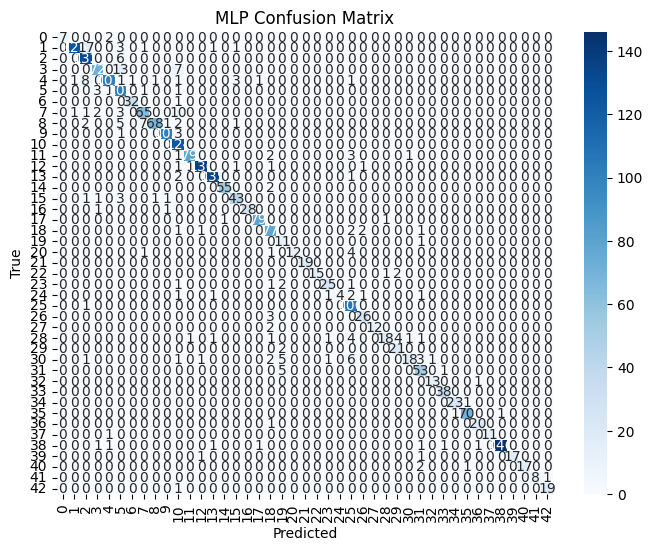

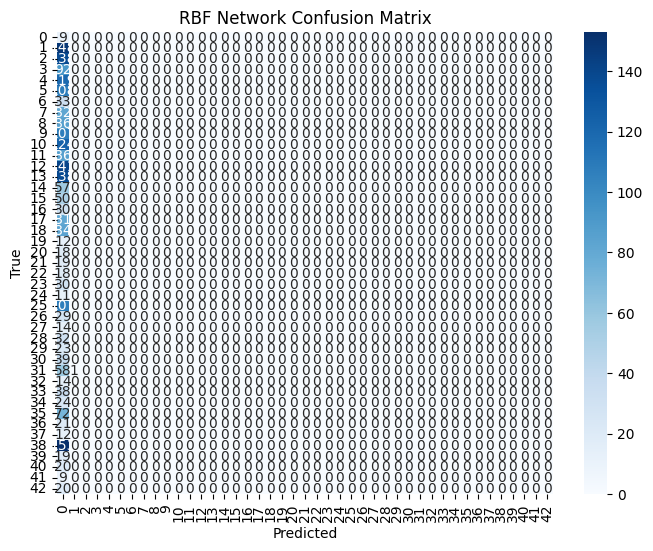

MLP Model Performance Metrics:
              precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       0.98      0.84      0.91       148
           2       0.81      0.96      0.88       138
           3       0.90      0.78      0.84        92
           4       0.95      0.85      0.90       119
           5       0.74      0.94      0.83       108
           6       0.97      0.97      0.97        33
           7       0.87      0.79      0.83        82
           8       0.97      0.79      0.87        86
           9       0.97      0.96      0.97       107
          10       0.78      1.00      0.88       124
          11       0.98      0.92      0.95        86
          12       0.98      0.96      0.97       141
          13       0.97      0.98      0.97       138
          14       0.98      0.96      0.97        57
          15       0.88      0.86      0.87        50
          16       1.00      0.93      0.97       

/Users/mohammadsalah/Desktop/GTSRB/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mohammadsalah/Desktop/GTSRB/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mohammadsalah/Desktop/GTSRB/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [73]:
# Confusion Matrix and Performance Metrics

# MLP Confusion Matrix
mlp_cm = confusion_matrix(test_labels, mlp_predictions)

# RBF Confusion Matrix (rounded predictions as it's for classification)
rbf_cm = confusion_matrix(test_labels, np.round(predictions))

# Plotting the confusion matrices using Seaborn heatmap
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot confusion matrices for both models
plot_confusion_matrix(mlp_cm, 'MLP')
plot_confusion_matrix(rbf_cm, 'RBF Network')

# MLP Performance Metrics
print("MLP Model Performance Metrics:")
print(classification_report(test_labels, mlp_predictions))

# RBF Network Performance Metrics (rounded predictions)
print("RBF Network Performance Metrics:")
print(classification_report(test_labels, np.round(predictions)))